In [3]:
import os
import re

import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt

import collections
import wordcloud as wc

import nltk

from sklearn.feature_extraction.text import CountVectorizer

### Dataset initial

In [4]:
input_path = "data/cdiscount_train.csv.zip"
nb_line=100000
data_all = pd.read_csv(input_path, sep=",", nrows=nb_line)
data_all = data_all.fillna("") # pour les valeurs nulles
data_all.head()

,Categorie1,Categorie2,Categorie3,Description,Libelle,Marque
0,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,Batterie Acer Aspire One 751H-52Yr,AUCUNE
1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,Coque rigide Bleu lagon pour ALCATEL OT / 6033 …,MUZZANO
2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...,Facades et coques CELLULAR LINE SHCKGALS 3 MINIP,CELLULAR LINE
3,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque meteore TPU LG Nexus 4 / E960,Coque meteore TPU LG Nexus 4 / E960,AUCUNE
4,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE - BUMPER - FACADE TELEPHONE,Coque souple Transparente pour LG G FLEX D959 ...,Coque souple Transparente pour LG G FLEX D959 m…,MUZZANO


## Dataset utilisé

In [5]:
data = data_all[["Categorie1","Description"]]
print(type(data))
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
(100000, 2)


In [6]:
data.head()

,Categorie1,Description
0,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...
1,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...
2,TELEPHONIE - GPS,Facades et coques CELLULAR LINE SHCKGALS 3 MIN...
3,TELEPHONIE - GPS,Coque meteore TPU LG Nexus 4 / E960
4,TELEPHONIE - GPS,Coque souple Transparente pour LG G FLEX D959 ...


## Stats descriptives

In [7]:
data.describe(include='all')

,Categorie1,Description
count,100000,100000
unique,44,96591
top,TELEPHONIE - GPS,4400mAh | 10.8V | Li-ion - 4400mAh | 10.8V | L...
freq,21325,97


#### Comments :

- Categorie avec le + de produits : Telephonie-GPS
- 44 catégories au total
- 100000 produits
- 3500 decriptions sont identiques

In [8]:
data['Categorie1'].value_counts()
cat_list=data['Categorie1'].value_counts().index.tolist()

In [9]:
data[data['Categorie1']=="PRODUITS FRAIS"] #recup une ligne spécifique

,Categorie1,Description
52370,PRODUITS FRAIS,NATINE - Mes tartines au millet - SANS SEL - B...
65640,PRODUITS FRAIS,Pain au chocolat - PASQUIER - Pain au chocolat...
84471,PRODUITS FRAIS,"Riz cantonais - Riz cuit 57,4% (riz - eau - br..."
89657,PRODUITS FRAIS,Yaourt brassé nature - VELOUTE - Yaourt brassé...


In [10]:
freq = data.groupby("Categorie1")
freq

In [11]:
nb = freq.count()
freq_cat = nb.sort_values("Description", ascending=False)
effectif= sum(freq_cat["Description"])
freq_cat["Description"]=freq_cat["Description"]*100/effectif
freq_cat.head()

,Description
Categorie1,
TELEPHONIE - GPS,21.325
INFORMATIQUE,14.597
LIBRAIRIE,12.121
VETEMENTS - LINGERIE,6.023
BIJOUX - LUNETTES - MONTRES,6.014


<Figure size 432x288 with 0 Axes>

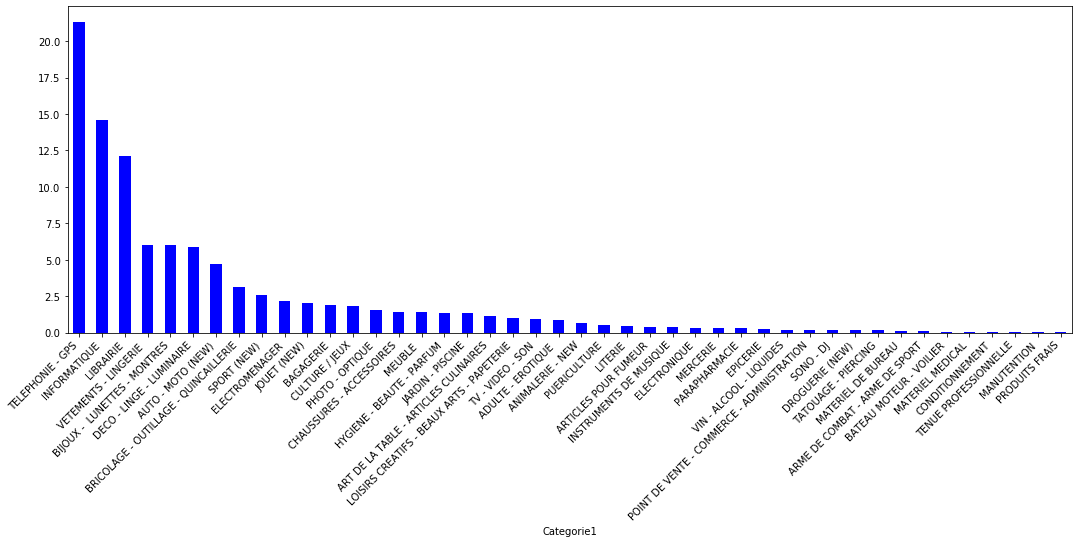

In [12]:


fig=plt.figure()
ax =freq_cat.plot(kind = "bar", figsize=(18,6), color='b')
ax.set_xticklabels(cat_list, rotation=45, ha='right')
#ax.set_xlabel("Categories", fontsize=16)
#plt.title("Number of products by categories", fontsize=16)
ax.legend().set_visible(False)  # supprime la légende


In [13]:
print((data['Categorie1']=="LIBRAIRIE").value_counts())

False    87879
True     12121
Name: Categorie1, dtype: int64


## Création d'un dataframe du vocab / catégorie

In [14]:
cat = data['Categorie1'].unique().tolist() #liste des categories 
print(cat_list)

['TELEPHONIE - GPS', 'INFORMATIQUE', 'LIBRAIRIE', 'VETEMENTS - LINGERIE ', 'BIJOUX -  LUNETTES - MONTRES', 'DECO - LINGE - LUMINAIRE', 'AUTO - MOTO (NEW)', 'BRICOLAGE - OUTILLAGE - QUINCAILLERIE', 'SPORT (NEW)', 'ELECTROMENAGER', 'JOUET (NEW)', 'BAGAGERIE', 'CULTURE / JEUX', 'PHOTO - OPTIQUE', 'CHAUSSURES - ACCESSOIRES', 'MEUBLE ', 'HYGIENE - BEAUTE - PARFUM', 'JARDIN - PISCINE', 'ART DE LA TABLE - ARTICLES CULINAIRES', 'LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE', 'TV - VIDEO - SON', 'ADULTE - EROTIQUE ', 'ANIMALERIE - NEW', 'PUERICULTURE', 'LITERIE', 'ARTICLES POUR FUMEUR', 'INSTRUMENTS DE MUSIQUE', 'ELECTRONIQUE', 'MERCERIE', 'PARAPHARMACIE', 'EPICERIE', 'VIN - ALCOOL - LIQUIDES', 'POINT DE VENTE - COMMERCE - ADMINISTRATION', 'SONO - DJ', 'DROGUERIE (NEW)', 'TATOUAGE - PIERCING', 'MATERIEL DE BUREAU', 'ARME DE COMBAT - ARME DE SPORT', 'BATEAU MOTEUR - VOILIER', 'MATERIEL MEDICAL', 'CONDITIONNEMENT', 'TENUE PROFESSIONNELLE', 'MANUTENTION', 'PRODUITS FRAIS']


In [15]:
## Creation d'un data frame par categories
new = []
for i in cat_list :    
    voca = ""    
    c = data[data['Categorie1']==i].index #selectionne les lignes correspondantes a la categorie
    for index in c :
        voca += data['Description'][index]
        voca += " "
    new.append([i,voca]) #nom categorie + voca associé

df = pd.DataFrame(new,columns=['Categorie','Description'])
df.head()

,Categorie,Description
0,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...
1,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...
2,LIBRAIRIE,De Teo aux éditions EMMANUEL PROUST Saint Seiy...
3,VETEMENTS - LINGERIE,debardeur femme superman or - … Voir la présen...
4,BIJOUX - LUNETTES - MONTRES,Seiko SFP599 Hommes Montre - Acheter Authentiq...


In [16]:
i_frai = df[df['Categorie']=="PRODUITS FRAIS"].index 
frai = df['Description'][i_frai[0]] #recup vocabulaire de categorie produits frais
#print(frai.split(" "))
print("total : ", len(frai.split(" "))) #compte nb de mots
print("unique : ", len(set(frai.split(" ")))) #compte nb mots uniques

total :  102
unique :  58


In [17]:
# Verification avec les données initiales
index_frai = data[data['Categorie1']=="PRODUITS FRAIS"].index 
for i in index_frai :
    b = data['Description'][index_frai]
    
print(b)

52370    NATINE - Mes tartines au millet - SANS SEL - B...
65640    Pain au chocolat - PASQUIER - Pain au chocolat...
84471    Riz cantonais - Riz cuit 57,4% (riz - eau - br...
89657    Yaourt brassé nature - VELOUTE - Yaourt brassé...
Name: Description, dtype: object


### Afficher nb de mots unique par categorie

In [18]:
nb = []
uniq = []

for cat_i in range(44) :
    voc_cat_i = df['Description'][cat_i]
    nb.append(len(voc_cat_i.split(" ")))
    uniq.append(len(set(voc_cat_i.split(" "))))

In [19]:
df['Total words'] = nb
df['Uniq words'] = uniq
data_voc = df
data_voc.head()

,Categorie,Description,Total words,Uniq words
0,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,666273,24823
1,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,350279,34009
2,LIBRAIRIE,De Teo aux éditions EMMANUEL PROUST Saint Seiy...,104108,22468
3,VETEMENTS - LINGERIE,debardeur femme superman or - … Voir la présen...,155486,22869
4,BIJOUX - LUNETTES - MONTRES,Seiko SFP599 Hommes Montre - Acheter Authentiq...,151162,19582


Ajout de colonnes pour les step 1,2,3 du cleaning:

In [20]:

step1 = []
step2 =[]
step3 = []

for cat_i in range(44) :
    voc_cat_i = data_voc['Description'][cat_i]
    
    #step1
    cleaned_voc = voc_cat_i
    cleaned_voc = cleaned_voc.lower()#put the vocabulary in lower
    cleaned_voc = cleaned_voc.replace(u'\u2026','.') #removing special character 
    cleaned_voc = cleaned_voc.replace(u'\u00a0',' ') 
    cleaned_voc = cleaned_voc.replace(u'\u005F',' ') # removing '_'
    cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8") #takes off some punctuation
    cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc)
    step1.append(len(set(cleaned_voc.split(" "))))
    
    
    #STEP 2 : Removing french/english stopwords using NLTK
    #stopwords = nltk.corpus.stopwords.words('french') 
    #stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
    stopwords = []
    stopwords += ["voir"]
    stopwords += ["presentation"]
    
    #stopwordsenglish = nltk.corpus.stopwords.words('english')
    #stopwordsenglish = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwordsenglish]
   
    
    tokens = [w for w in cleaned_voc.split(" ") if (len(w)>=2) and (w not in stopwords)] #and (w not in stopwordsenglish)]
    removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords)] #or (w in stopwordsenglish)]
    step2.append(len(set(tokens)))
    
    #STEP 3 : Stemming
    stemmer=nltk.stem.SnowballStemmer('french')
    
    tokens_stem = [stemmer.stem(token) for token in tokens]
    step3.append(len(set(tokens_stem)))

data_voc['Unique words first clean']=step1
data_voc["Unique words without stop words"]=step2
data_voc["Unique and final tokens"]=step3

In [21]:
data_voc.head()

,Categorie,Description,Total words,Uniq words,Unique words first clean,Unique words without stop words,Unique and final tokens
0,TELEPHONIE - GPS,Coque rigide Bleu lagon pour ALCATEL OT / 6033...,666273,24823,10956,10927,8721
1,INFORMATIQUE,Batterie Acer Aspire One 751H-52Yr - Li-Ion 11...,350279,34009,8315,8286,6932
2,LIBRAIRIE,De Teo aux éditions EMMANUEL PROUST Saint Seiy...,104108,22468,17003,16974,14944
3,VETEMENTS - LINGERIE,debardeur femme superman or - … Voir la présen...,155486,22869,11424,11395,9255
4,BIJOUX - LUNETTES - MONTRES,Seiko SFP599 Hommes Montre - Acheter Authentiq...,151162,19582,8680,8651,6952


In [25]:
main_cat = data_voc['Categorie'][0:4].tolist() #recup valeurs d'une colonne
main_tot = data_voc['Total words'][0:4].tolist()
main_uniq = data_voc['Uniq words'][0:4].tolist()

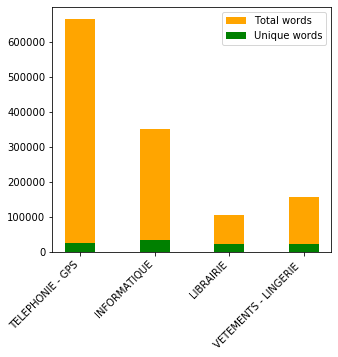

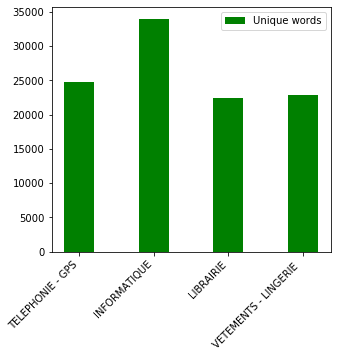

In [56]:
fig = plt.figure(figsize=(5,5))
plt.bar(main_cat,main_tot,width = 0.4, color = 'orange', label="Total words")
plt.bar(main_cat,main_uniq,width = 0.4, color = 'green', label="Unique words")
#plt.title("Size of vocabulary for main categories")
plt.legend()
fig.autofmt_xdate(rotation=45)


fig = plt.figure(figsize=(5,5))
plt.bar(main_cat,main_uniq,width = 0.4, color = 'green', label="Unique words")
#plt.title("Size of vocabulary for main categories")
plt.legend()
fig.autofmt_xdate(rotation=45)

## Cleaning

### Clean sur un string

In [82]:
#vocabulaire TOTAL, toutes catégories confondues

voca = "" 
for k in range(nb_line):
    des = data['Description'][k]
    voca += " "
    voca += des

In [5]:
def cleaning(voca) :
    #print("Cleaning function :")
    #print("Total words :" ,len(voca.split(" ")))
    #print("Unique words :" ,len(set(voca.split(" "))))
    #print("Ratio words :" , len(voca.split(" "))/len(set(voca.split(" "))), "\n \n")

    
    #STEP 1 : Standardization
    cleaned_voc = voca
    cleaned_voc = cleaned_voc.lower()
    cleaned_voc = cleaned_voc.replace(u'\u2026','.') #put the vocabulary in lower
    cleaned_voc = cleaned_voc.replace(u'\u00a0',' ') #removing special character 
    cleaned_voc = cleaned_voc.replace(u'\u005F',' ')
    cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8") #takes off some punctuation
    cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc) # keeps only alphabet letters
    #print("Total after step 1 :", len(cleaned_voc.split(" ")))
    # print("Uniq after step 1 :", len(set(cleaned_voc.split(" "))) , "\n \n")

    
    #STEP 2 : Removing french stopwords using NLTK
    stopwords = nltk.corpus.stopwords.words('french') 
    stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
   
    stopwords += ["voir"]
    stopwords += ["presentation"]
    
    
    #stopwordsenglish = nltk.corpus.stopwords.words('english')
    #stopwordsenglish = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwordsenglish]
   
    
    tokens = [w for w in cleaned_voc.split(" ") if (len(w)>=2) and (w not in stopwords)]
    removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords)]
    #print("Total after step 2 :", len(tokens))
    #print("Uniq after step 2 :", len(set(tokens)) , "\n \n")
    
    #STEP 3 : Stemming
    stemmer=nltk.stem.SnowballStemmer('french')
    stemmer2=nltk.stem.SnowballStemmer('english')
    tokens_stem = [stemmer2.stem(token) for token in tokens]
    tokens_stem = [stemmer.stem(token) for token in tokens]
    
    #print("Total tokens after step 3 :" , len(tokens_stem))
    #print("Unique tokens after step 3 :" ,len(set(tokens_stem)))
    #print("Ratio tokens :" , len(tokens_stem)/len(set(tokens_stem)))
    
    voca_cleaned = ""
    
    for t in tokens_stem :
        voca_cleaned += t
        voca_cleaned += " "
    voca_cleaned=voca_cleaned[:-1]
    return voca_cleaned

In [6]:
def cleaning_wstop(voca) :
    #print("Cleaning function :")
    #print("Total words :" ,len(voca.split(" ")))
    #print("Unique words :" ,len(set(voca.split(" "))))
    #print("Ratio words :" , len(voca.split(" "))/len(set(voca.split(" "))), "\n \n")

    
    #STEP 1 : Standardization
    cleaned_voc = voca
    cleaned_voc = cleaned_voc.lower()
    cleaned_voc = cleaned_voc.replace(u'\u2026','.') #put the vocabulary in lower
    cleaned_voc = cleaned_voc.replace(u'\u00a0',' ') #removing special character 
    cleaned_voc = cleaned_voc.replace(u'\u005F',' ')
    cleaned_voc = unicodedata.normalize('NFD', cleaned_voc).encode('ascii', 'ignore').decode("utf-8") #takes off some punctuation
    cleaned_voc = re.sub('[^a-z_]', ' ', cleaned_voc) # keeps only alphabet letters
    #print("Total after step 1 :", len(cleaned_voc.split(" ")))
    # print("Uniq after step 1 :", len(set(cleaned_voc.split(" "))) , "\n \n")

    
    #STEP 2 : Removing french stopwords using NLTK
    #stopwords = nltk.corpus.stopwords.words('french') 
    #stopwords = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwords]
    stopwords=[]
    stopwords += ["voir"]
    stopwords += ["presentation"]
    
    
    #stopwordsenglish = nltk.corpus.stopwords.words('english')
    #stopwordsenglish = [unicodedata.normalize('NFD', sw).encode('ascii', 'ignore').decode("utf-8") for sw in stopwordsenglish]
   
    
    tokens = [w for w in cleaned_voc.split(" ") if (len(w)>=2) and (w not in stopwords)]# and (w not in stopwordsenglish)]
    removed_words = [w for w in cleaned_voc.split(" ") if (len(w)<2) or (w in stopwords)]# or (w in stopwordsenglish)]
    #print("Total after step 2 :", len(tokens))
    #print("Uniq after step 2 :", len(set(tokens)) , "\n \n")
    
    #STEP 3 : Stemming
    stemmer=nltk.stem.SnowballStemmer('french')
    stemmer2=nltk.stem.SnowballStemmer('english')
    tokens_stem = [stemmer2.stem(token) for token in tokens]
    tokens_stem = [stemmer.stem(token) for token in tokens]
    
    #print("Total tokens after step 3 :" , len(tokens_stem))
    #print("Unique tokens after step 3 :" ,len(set(tokens_stem)))
    #print("Ratio tokens :" , len(tokens_stem)/len(set(tokens_stem)))
    
    voca_cleaned = ""
    
    for t in tokens_stem :
        voca_cleaned += t
        voca_cleaned += " "
    voca_cleaned=voca_cleaned[:-1]
    return voca_cleaned

In [111]:
data = data_all[["Categorie1","Description"]]
list_data = []
list_data_wstop =[]
for cat, desc in data.values:
    list_data.append([cat, cleaning(desc)]) 
    list_data_wstop.append([cat,cleaning_wstop(desc)])

In [112]:
print(list_data[0:10])
print(list_data_wstop[0:10])

[['INFORMATIQUE', 'batter acer aspir one yr li ion mah wh noir compatibl batter'], ['TELEPHONIE - GPS', 'coqu rigid bleu lagon alcatel ot motif drapeau liberi film coqu rigid ultra fin bleu lagon original muzzano motif drapeau liberi alcatel'], ['TELEPHONIE - GPS', 'facad coqu cellular lin shckgal minip marqu agree samsungmobil compatibl galaxy minimatier caoutchouc soupl'], ['TELEPHONIE - GPS', 'coqu meteor tpu lg nexus'], ['TELEPHONIE - GPS', 'coqu soupl transparent lg flex motif keep calm and play football coqu soupl ultra fin transparent original muzzano motif keep calm and play footbal'], ['TELEPHONIE - GPS', 'compatibilit iphon iphon caracterist etuis corp enti styl couleur uni couleur blanc noir ros'], ['BIJOUX -  LUNETTES - MONTRES', 'seiko sfp homm montr achet authent seiko sfp regard lign prix reduit infiniteshopping'], ['ARTICLES POUR FUMEUR', 'pack fruit expert titanium bleu mixt mg ml mg ml quel dosag liquid mg ml san nicotin ancien fumeur sevr mg ml conseil'], ['SPORT (NE

In [89]:
data_cleaned_100k = pd.DataFrame(list_data,columns= ["Categorie1","Description"]) 
data_cleaned_100k_wstop= pd.DataFrame(list_data_wstop,columns=["Categorie1","Description"])
data_cleaned_100k.to_csv("data/data_cleaned_100k.csv", index=False)
data_cleaned_100k_wstop.to_csv("data/data_cleaned_100k_wstop.csv",index=False)

## Fonction création dataframe

In [13]:
def create_data(nb_lines,wstops):
    #chargement dataset 
    input_path = "data/cdiscount_train.csv.zip"
    data_all = pd.read_csv(input_path, sep=",", nrows=nb_lines)
    data_all = data_all.fillna("") # pour les valeurs nulles
    data = data_all[["Categorie1","Description"]]
    
    #cleaning du data set
    if not wstops:
        list_data =[]
        for cat, desc in data.values:
            list_data.append([cat,cleaning(desc)])
        data_cleaned = pd.DataFrame(list_data,columns= ["Categorie1","Description"])
        string="data/data_cleaned_"
        if nb_lines==1000000:
            string+="1M"
        else:    
            string+= str(nb_lines)[0:3]
        string+=".csv"
        data_cleaned.to_csv(string, index=False)
        print("Saved in",string)
        return
    else:
        list_data_wstop =[]
        for cat, desc in data.values:
            list_data_wstop.append([cat, cleaning_wstop(desc)]) 
        data_cleaned_wstop= pd.DataFrame(list_data_wstop,columns=["Categorie1","Description"])
        string="data/data_cleaned_wstop_"
        if nb_lines==1000000:
            string+="1M"
        else:   
            string+= str(nb_lines)[0:3]
        string+="k.csv"
        data_cleaned_wstop.to_csv(string, index=False)
        print("Saved in",string)
        return

In [14]:
create_data(100000,True)
create_data(100000,False)

Saved in data/data_cleaned_wstop_100k.csv
Saved in data/data_cleaned_100.csv
